In [1]:
import pandas as pd
import numpy as np
import sklearn.ensemble
import lime.lime_tabular_mod
import matplotlib.pyplot as plt
import random

import importlib
importlib.reload(lime.lime_tabular_mod)

pd.set_option("display.max_columns", None)
pd.set_option("mode.chained_assignment", None)
plt.style.use({"figure.facecolor": "white"})

### Load iris dataset
This dataset will be used as an example

In [2]:
iris_dataset = pd.read_csv(
    "../data/iris-classification/iris.data",
    names=[
        "sepal_length",
        "sepal_width",
        "petal_length",
        "petal_width",
        "label"
    ]).sample(frac=1)
iris_dataset

,sepal_length,sepal_width,petal_length,petal_width,label
145,6.7,3.0,5.2,2.3,Iris-virginica
47,4.6,3.2,1.4,0.2,Iris-setosa
102,7.1,3.0,5.9,2.1,Iris-virginica
1,4.9,3.0,1.4,0.2,Iris-setosa
76,6.8,2.8,4.8,1.4,Iris-versicolor
...,...,...,...,...,...
51,6.4,3.2,4.5,1.5,Iris-versicolor
35,5.0,3.2,1.2,0.2,Iris-setosa
21,5.1,3.7,1.5,0.4,Iris-setosa
25,5.0,3.0,1.6,0.2,Iris-setosa


### Prepare test set using jackknife method - single data instance
Instance will be used for explaining Random Forest prediction


In [3]:
labels_column_name = "label"
jackknife_idx = random.choice(iris_dataset.index.to_numpy())
train_data = iris_dataset.loc[iris_dataset.index != jackknife_idx]
train_x = train_data.drop(columns=labels_column_name).to_numpy()
train_y = train_data[labels_column_name].to_numpy()
test_data = iris_dataset.loc[iris_dataset.index == jackknife_idx]
test_x = test_data.drop(columns=labels_column_name).to_numpy()
test_y = test_data[labels_column_name].to_numpy()

attributes = iris_dataset.columns.tolist()
attributes.remove(labels_column_name)
print(f"Attributes: {attributes}")

model = sklearn.ensemble.RandomForestClassifier()
model.fit(train_x, train_y)

Attributes: ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']


RandomForestClassifier()

Get prediction of explained model

In [4]:
prediction = model.predict(test_x)
prediction_probabilities = model.predict_proba(test_x)[0]
print(f"Predicted: {prediction}. Probabilities: {prediction_probabilities}")

Predicted: ['Iris-versicolor']. Probabilities: [0. 1. 0.]


## Use modified LIME to explain prediction
### Create explainer object
At first create explainer object that makes use of training data.
It may be used by discretizer inner object and enhance local surrogate's performance.

In [5]:
explainer = lime.lime_tabular_mod.LimeTabularExplainerMod(
    train_x,
    feature_names = attributes,
    class_names = model.classes_,
    discretize_continuous=False,
    sample_around_instance=True
)

### Explain test instance
Print explanations for two labels with the greatest prediction probabilities

,sepal_length,sepal_width,petal_length,petal_width,label
94,5.6,2.7,4.2,1.3,Iris-versicolor


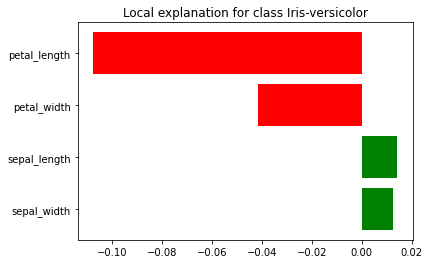

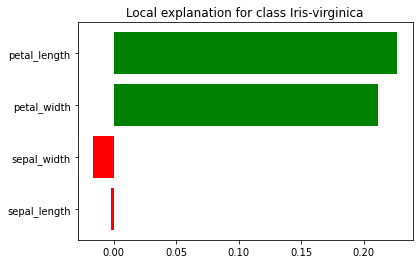

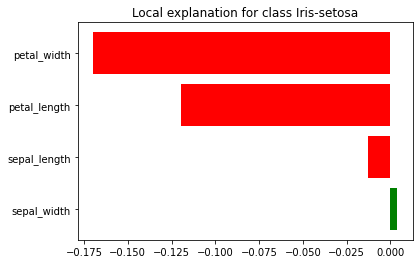

In [6]:
explanation = explainer.explain_instance(
    test_x.ravel(),
    model.predict_proba,
    num_features = 4,
    top_labels = 3,
    # distance_metric="minkowski",
    # minkowski_norm=100.
)
for label in explanation.top_labels[:3]:
    _ = explanation.as_pyplot_figure(label)

# show explained instance
iris_dataset.loc[iris_dataset.index == jackknife_idx]

## Assess the explanation

Compare predictions of explained model and local surrogate on explained data instance:

In [7]:
print(explanation.get_prediction_for_explained_model())
print(explanation.get_prediction_for_surrogate_model(normalized=True))


[0.0, 1.0, 0.0]
[0.16201143, 0.5091869, 0.3288016]


Check scores and losses of sub-explainers that are local surrogate consists of:

In [8]:
print(explanation.get_scores_for_surrogate_model())
print(explanation.get_losses_for_surrogate_model())

[0.5029039372757205, 0.10435286663175503, 0.6597475742190111]
[0.034380018196349095, 0.08573347958870256, 0.0368939750548177]


Compare fidelity of local surrogate on explained instance and on the generated dataset.
For fidelity methods MSE (mean square error) is used.

In [9]:
print(explanation.get_fidelity_loss_on_explanation())
print(explanation.get_fidelity_loss_on_generated_data())


0.12508522432085534
0.045658384211148186


Unfortunately, due to the sampling method that is far from perfect,
fidelity loss on explanation is significantly greater.

One can check fidelity loss map for generated data instances:

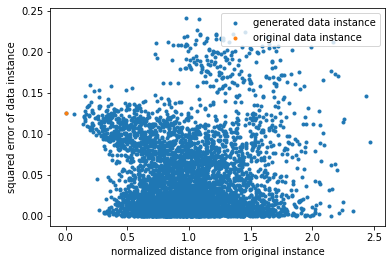

In [10]:
squared_errors = explanation.get_fidelity_loss_distribution()
explanation.plot_fidelity_map()

Histograms of errors and normalised distances from original instance are plotted below:

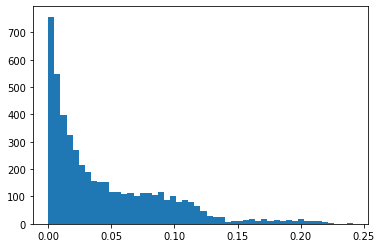

In [11]:
plt.hist(squared_errors, bins=50)
plt.show()

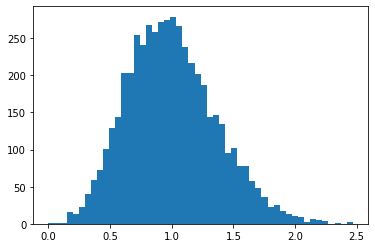

In [12]:
plt.hist((squared_errors.index)/np.mean(squared_errors.index.values), bins=50)
plt.show()

Surprisingly and sadly enough, distribution of distances from generated instances to explained one is
unintuitive. That is the reason why **explained instance is actually the worst explained**.

Knowing that local surrogate explains models only locally, one can check how
**fidelity loss** changes on increasing distance from explained instance
(spatial distribution of fidelity loss).

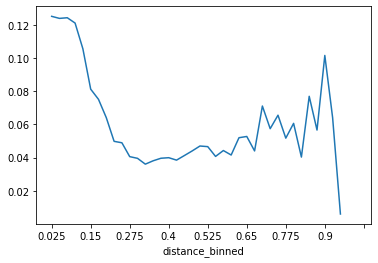

In [13]:
binned = explanation.get_fidelity_loss_distribution(bins=40)
binned.plot()
plt.show()

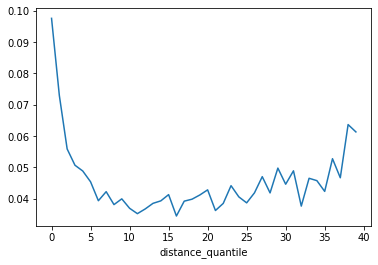

In [14]:
percentiles = explanation.get_fidelity_loss_distribution(quantiles=40)
percentiles.plot()
plt.show()